# San Francisco Crime Classification
### Predicting the category of crimes that occurred in the city by the bay

From 1934 to 1963, San Francisco was infamous for housing some of the world's most notorious criminals on the inescapable island of Alcatraz.


From Sunset to SOMA, and Marina to Excelsior, this competition's dataset provides nearly 12 years of crime reports from across all of San Francisco's neighborhoods. Given time and location, you must predict the category of crime that occurred.


------

# Prediction

After performing Exploratory Data Analysis and determining some important predicotrs for predicting the crime category, it is now time to the perform machine learning pipeline. Note some of this will be the same as above

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import re
from tqdm import tqdm
from pandas.api.types import is_string_dtype, is_numeric_dtype
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.exceptions import DataConversionWarning
from sklearn_pandas import DataFrameMapper

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

warnings.filterwarnings('ignore', category=DataConversionWarning)

# read in train and test
DATA_PATH = Path('data/')
train = pd.read_csv(DATA_PATH / 'train.csv')
test = pd.read_csv(DATA_PATH / 'test.csv')

# drop columns not in test
train.drop(['Descript', 'Resolution', 'DayOfWeek'], axis = 1, inplace = True)

all_data = pd.concat([train, test], axis = 0)
print('train shape', train.shape)
print('test shape', test.shape)
train.head()

# params 
EMBEDDING_MODEL = False
DUMMY = False
SCALE_NUM = True
CREATE_CATS = True

train shape (878049, 6)
test shape (884262, 7)


### Transfrom Dates 
We can add many more field here, such as 
- Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Minute', 'Hour', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start'

In [2]:
def transform_date(df, field_name, drop=True):
    field = df[field_name]
    if not np.issubdtype(field, np.datetime64):
        df[field_name] = field = pd.to_datetime(field, infer_datetime_format=True)
    target_pre = re.sub('[Dd]ate$', '', field_name)
    for i in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Minute', 'Hour'):
        df[target_pre + i] = getattr(field.dt, i.lower())
    df[target_pre + 'Elapsed'] = field.astype(np.int64) // 10**9
    df[target_pre + 'Minute30'] = (df[target_pre + 'Minute'] - 60 / 2) % 60 
    df[target_pre + 'Hour12'] = (df[target_pre + 'Hour'] - 12 / 2) % 12
    df[target_pre + 'Week26'] = (df[target_pre + 'Week'] - 52 / 2) % 52 
    df[target_pre + 'Month6'] = (df[target_pre + 'Month'] - 12 / 2) % 12
    if drop:
        df.drop(field_name, axis=1, inplace=True)
        

In [3]:
for dat in (train, test):
    transform_date(dat, 'Dates', drop=True)

- `Block` - Add 1 for column if block occurs in address and add 1 if it is at an intersection
- `Number` - If there is a number in the address
- `Intersection` - If the adress is at an intersection
- `EndAddress` - Pluck out the last value, such as ST, AV

In [4]:
for dat in (train, test):
    dat['Block'] = dat.Address.map(lambda x: 1 if 'block' in x.lower() else 0).astype(np.float64)
    dat['EndAddress'] = dat.Address.map(lambda x: x[-2:])
    dat['Number'] = dat.Address.map(lambda x: any(char.isdigit() for char in x))
    dat['Intersection'] = dat.Address.map(lambda x: 1 if '/' in x else 0).astype(np.float64)

Mean Encodings 
- This type of encoding is called likelihood encoding, impact coding or target coding
- min_samples_leaf define a threshold where prior and target mean (for a given category value) have the same weight. Below the threshold prior becomes more important and above mean becomes more important.
- How weight behaves against value counts is controlled by smoothing parameter

In [5]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):

    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)


mean_enc_features = ['PdDistrict', 'Address', 'EndAddress']
for enc_feat in tqdm(mean_enc_features):
    for target in train['Category'].unique():
        train[target + '_BINARY'] = train['Category'].map(lambda x: 1 if x == target else 0)
        f_name = enc_feat + '_' + target + '_smooth'
        train[f_name], test[f_name] = target_encode(train[enc_feat], 
                                 test[enc_feat], 
                                 target=train[target + '_BINARY'], 
                                 min_samples_leaf=100,
                                 smoothing=10,
                                 noise_level=0.01)
        
        train.drop([target + '_BINARY'], axis=1, inplace=True)


100%|██████████| 3/3 [01:52<00:00, 37.47s/it]


Log Odds for Address field 

In [6]:
%%time
# log odds
rare_cats = set(['FAMILY OFFENSES', 'BAD CHECKS', 'BRIBERY', 'EXTORTION','SEX OFFENSES NON FORCIBLE', 
                 'GAMBLING', 'PORNOGRAPHY/OBSCENE MAT', 'TREA'])
all_cats = set(train['Category'].unique())
common_cats = all_cats - rare_cats

DEFAULT_RATIO = np.log(1.0 / len(common_cats))
MIN_COUNT = 5

address_counts = pd.DataFrame(train.groupby(['Address']).size(), columns = ['total_count'])
        
#determine number of crimes by category and address
address_category_counts = pd.DataFrame(train.groupby(['Address', 'Category']).size(), columns = ['count']).reset_index()

address_category_counts['total_count'] = address_category_counts.groupby('Address')['count'].transform(lambda x: max(MIN_COUNT, x.sum()))
address_category_counts = address_category_counts[address_category_counts['count'] >= MIN_COUNT]
address_category_counts['log'] = (address_category_counts['count'] / address_category_counts['total_count']).apply(np.log)

#form pivot table
log_ratios = pd.pivot_table(address_category_counts, index = 'Address', 
                  columns = 'Category', values = 'log', fill_value = DEFAULT_RATIO) - DEFAULT_RATIO  
log_ratios.columns = ['LogRatio_' + str(x) for x in range(len(log_ratios.columns))]

#join total counts
log_ratios = log_ratios.merge(address_counts, 'left', left_index = True, right_index = True)


# train
merged_data_train = train.loc[:, 'Address'].reset_index().merge(log_ratios, how='left', left_on='Address', right_index=True).iloc[:,2:]        
train = train.join(merged_data_train)
train.total_count = train.total_count.fillna(MIN_COUNT)
train.fillna(0.0, inplace=True)

# # test 
merged_data_test = test.loc[:, 'Address'].reset_index().merge(log_ratios, how='left', left_on='Address', right_index=True).iloc[:,2:]        
test = test.join(merged_data_test)
test.total_count = test.total_count.fillna(MIN_COUNT)
test.fillna(0.0, inplace=True)

del merged_data_train
del merged_data_test
del log_ratios

CPU times: user 5.98 s, sys: 1.65 s, total: 7.63 s
Wall time: 7.61 s


In [10]:
# for dat in (train, test):
#     dat.drop(['DayOfWeek', 'PdDistrict', 'EndAddress', 'Address'], axis = 1, inplace = True)

Coordinates 

ideas 

date
- time since something 
- holiday 
- days till holiday

Coordinates 
- distance to important location (att, bridge, niner) DONE
- cluster data (center of clusters as important points) DONE
- groupby number 
- calculate aggregated statistics for objects surrounding area. How expensive area is, etc....
- rotations of coord - all types 22.5, 45 (for DT) DONE 

rotate coordinates, for DT models 

In [8]:
for dat in (train, test):
    dat['rot45_X'] = .707* dat['Y'] + .707* dat['X'] 
    dat['rot45_Y'] = .707* dat['Y'] - .707* dat['X']

    dat['rot30_X'] = (1.732/2)* dat['X'] + (1./2)* dat['Y'] 
    dat['rot30_Y'] = (1.732/2)* dat['Y'] - (1./2)* dat['X']

    dat['rot60_X'] = (1./2)* dat['X'] + (1.732/2)* dat['Y'] 
    dat['rot60_Y'] = (1./2)* dat['Y'] - (1.732/2)* dat['X']

    dat['radial_r'] = np.sqrt(np.power(dat['Y'], 2) + np.power(dat['X'], 2))

distance from popular locations 

In [9]:
civic_center = (37.779756, -122.4163387)
golden_gate = (37.8199, -122.4783)
fisherman_warf = (37.8080, -122.4177)
china_town = (37.7941, -122.4078)
union_square = (37.7880, -122.4075)
att_park = (37.7786, -122.3893)

name_map = {
    'civic_center' : civic_center,
    'golden_gate' : golden_gate,
    'fisherman_warf' : fisherman_warf,
    'china_town' : china_town,
    'union_square': union_square,
    'att_park' : att_park,
}

for dat in (train, test):
    for name, var in name_map.items():
        dat['distance_' + name] = np.sqrt(np.square(dat['X'] - dat['Y']) + np.square(var[0] - var[1]))

Clustering

In [10]:
import matplotlib.cm as cm

def cluster_results(data, preds, centers):
    predictions = pd.DataFrame(preds, columns = ['Cluster'])
    plot_data = pd.concat([predictions, data.reset_index()], axis = 1)

    fig, ax = plt.subplots(figsize = (14,8))

    # Color map
    cmap = cm.get_cmap('gist_rainbow')

    # Color the points based on assigned cluster
    for i, cluster in plot_data.groupby('Cluster'):   
        cluster.plot(ax = ax, kind = 'scatter', x = 'X', y = 'Y', \
                     color = cmap((i)*1.0/(len(centers)-1)), label = 'Cluster %i'%(i), s=30);

    # Plot centers with indicators
    for i, c in enumerate(centers):
        ax.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', \
                   alpha = 1, linewidth = 2, marker = 'o', s=200);
        ax.scatter(x = c[0], y = c[1], marker='$%d$'%(i), alpha = 1, s=100);

silhouette_score : 0.49032587527984745 for num clusters 2
silhouette_score : 0.49734285881900075 for num clusters 3
silhouette_score : 0.489884265229634 for num clusters 4
silhouette_score : 0.4280172980980044 for num clusters 5
silhouette_score : 0.4423073129006975 for num clusters 6
silhouette_score : 0.4342116870867545 for num clusters 7
silhouette_score : 0.39214040122802246 for num clusters 8
silhouette_score : 0.39217883804137776 for num clusters 9
silhouette_score : 0.3924434589454095 for num clusters 10
silhouette_score : 0.3889037827779052 for num clusters 11
silhouette_score : 0.38540153025507945 for num clusters 12
silhouette_score : 0.3692382202329248 for num clusters 13


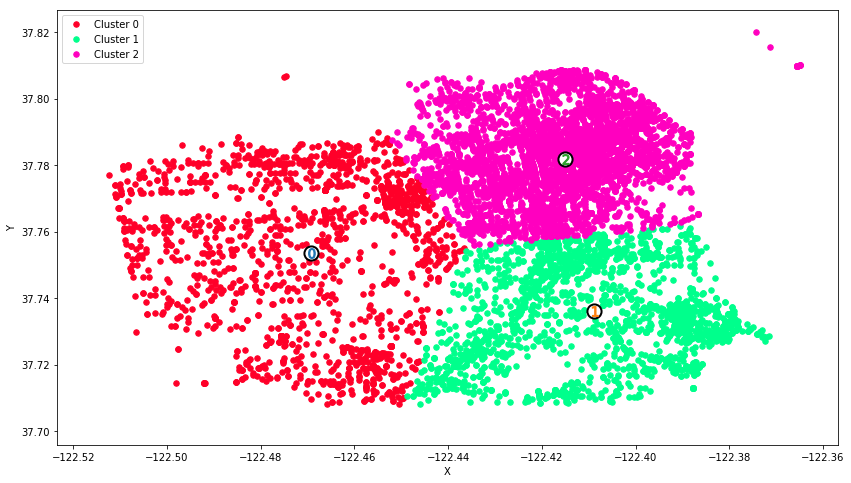

In [11]:
cluser_data = train[train.X < -122.00][['X', 'Y']].sample(10000)

best_score = 0.0
for k in range(2, 14):
    kmeans = KMeans(n_clusters=k, random_state=100)
    kmeans.fit(cluser_data)
    preds = kmeans.predict(cluser_data)
    centers = kmeans.cluster_centers_

    ss_score = silhouette_score(cluser_data, preds)
    print('silhouette_score : {} for num clusters {}'.format(ss_score, k))
    if ss_score > best_score:
        best_score = ss_score
        best_preds = preds
        best_centers = centers

cluster_results(cluser_data, best_preds, best_centers)

- 12 chosen based on insight
- reduce if overfitting 

0.38161615618998024


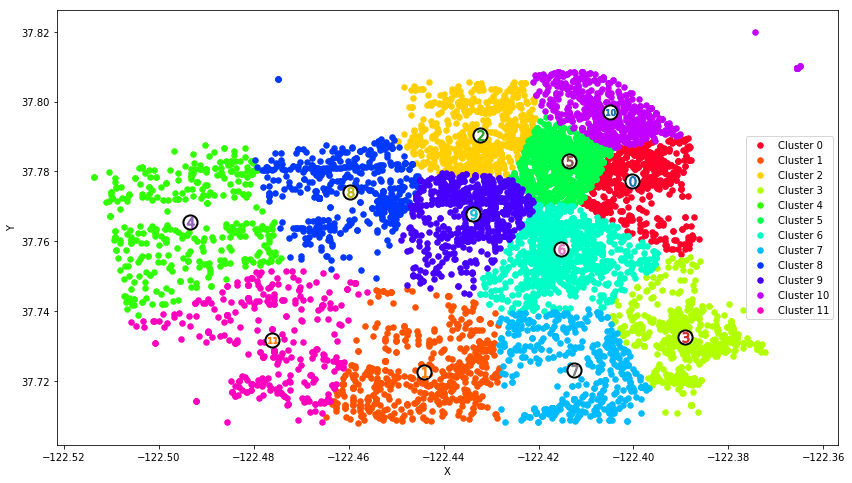

In [12]:
cluser_data = train[train.X < -122.00][['X', 'Y']].sample(10000, random_state=100)

kmeans = KMeans(n_clusters=12, random_state=100)
kmeans.fit(cluser_data)
preds = kmeans.predict(cluser_data)
centers = kmeans.cluster_centers_

ss_score = silhouette_score(cluser_data, preds)
print(ss_score)

cluster_results(cluser_data, preds, centers)

Calculate distance to each cluster center. 

In [13]:
for dat in (train, test):
    for i, center in enumerate(centers):
        dat['distance_cluster_center' + str(i)] = np.sqrt(np.square(dat['X'] - dat['Y']) + np.square(center[0] - center[1]))

In [14]:
for dat in (train, test):
    dat['cluster'] = kmeans.predict(dat[['X', 'Y']])
    dat['cluster'] = dat['cluster'].astype('object')

Transform `Category` field to numeric integers, just another way of doing LabelEncoder from sklearn with a 1 to 1 mapping

In [15]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train['Category'] = le.fit_transform(train['Category'])

Find all categorical columns and numeric ones. 

In [16]:
cat_cols = list(train.select_dtypes(include='object').columns)
num_cols = list(train.select_dtypes(exclude='object').columns)
cat_cols

['PdDistrict', 'Address', 'EndAddress', 'cluster']

Convert to category fields

In [17]:
def create_category_fields(df, is_train=True, train_df=None):  
    if is_train:
        for col_name, data in df.items():
            if is_string_dtype(data):
                df[col_name] = data.astype('category').cat.as_ordered()
    else:
        for col_name, data in df.items():
            if (col_name in train_df.columns) and (train_df[col_name].dtype.name == 'category'):
                df[col_name] = pd.Categorical(data, categories=train_df[col_name].cat.categories, ordered=True)

In [18]:
# # don't drop for NN embedding model 
if EMBEDDING_MODEL == False:
    train.drop(cat_cols, axis=1, inplace=True)
    test.drop(cat_cols + ['Id'], axis=1, inplace=True)
    
# Turn to category for Tree models
else:
    create_category_fields(train, is_train=True)
    create_category_fields(test, is_train=False, train_df=train)
    for dat in (train, test):
        for col in cat_cols:
            dat[col] = dat[col].astype('category').cat.codes

In [19]:
X = train.copy()
y = X.pop('Category').values

In [20]:
# find scale features  
date_cols_no_scale = [col for col in X.columns if col.startswith('DatesIs')]
smooth_col = [col for col in X.columns if 'smooth' in col]
mis_no_scale = ['Number', 'Block', 'Intersection']

no_scale = date_cols_no_scale + smooth_col + mis_no_scale + cat_cols
scale_cols = list(set(list(X.columns)).difference(no_scale))

In [21]:
# dummy variable or categorical 

dummy_feats = ['DatesYear', 'DatesMonth', 'DatesHour', 'DatesDay', 'DatesHour']
all_date_cols = [col for col in X.columns if col.startswith('Dates') and col not in date_cols_no_scale][:-1]

if EMBEDDING_MODEL:
    for dat in (train, test):
        for col in cat_cols + all_date_cols:
            dat[col] = dat[col].astype('category').cat.as_ordered()        
else:
    if DUMMY:
        n_train = train.shape[0]
        all_data = pd.concat((train, test), axis=0)
        all_data = pd.get_dummies(all_data, columns=dummy_feats)
        train = all_data[:n_train]
        test = all_data[n_train:]
        assert n_train == train.shape[0]

Split the data into training and testing sets from the original training set

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 100, stratify=y, test_size=0.1)
print(X_train.shape, X_test.shape)

(790244, 198) (87805, 198)


scale numerical features 

Scale numerical features 

In [23]:
scale_cols = list(set(list(X.columns)).difference(no_scale))

In [24]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

if SCALE_NUM:
    if EMBEDDING_MODEL:
        scale_cols = list(set(scale_cols).difference(all_date_cols))
        no_scale = no_scale + all_date_cols
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(X_train[scale_cols])
    X_train_num = pd.DataFrame(X_train_num, index=X_train[scale_cols].index, columns=X_train[scale_cols].columns)
    no_scale = list(set(no_scale).difference(cat_cols))
    X_train = X_train[no_scale].join(X_train_num)
    X_test_num = scaler.transform(X_test[scale_cols])
    X_test_num = pd.DataFrame(X_test_num, index=X_test[scale_cols].index, columns=X_test[scale_cols].columns)
    X_test = X_test[no_scale].join(X_test_num)


In [25]:
X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, stratify=y_train, test_size=0.75)
print(X_train_sample.shape, X_test.shape)

(197561, 198) (87805, 198)


In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import log_loss, accuracy_score


def print_score(clf, X_train, y_train, X_test, y_test, prob=True):
    import warnings
    warnings.filterwarnings('ignore')
    
    train_preds = clf.predict(X_train)
    test_preds = clf.predict(X_test)
    
    train_preds_prob = clf.predict_proba(X_train)
    test_preds_prob = clf.predict_proba(X_test)
    
    train_acc = accuracy_score(y_train, train_preds)
    test_acc = accuracy_score(y_test, test_preds)
    print('{} train/test classification accuracies: {:.3f}/{:.3f}'.format(
            clf.__class__.__name__, train_acc, test_acc))

    train_ll = log_loss(y_train, train_preds_prob, labels=clf.classes_)
    test_ll = log_loss(y_test, test_preds_prob, labels=clf.classes_)
    print('{} train/test log loss: {:.3f}/{:.3f}'.format(
            clf.__class__.__name__, train_ll, test_ll))


In [27]:
%%time
import lightgbm as lgb

my_params = {
    'device':'gpu',
    'num_class': len(le.classes_),
    'metric': 'multi_logloss',
    'objective': 'multiclass', 
    'max_depth': 7,
    'num_leaves': 25,
    'bagging_fraction': 0.75,
    'feature_fraction': 0.75,
    'min_data_in_leaf': 300, # important 
    'learning_rate': 0.1, # change later - trick after found correct num of round multiply num steps by alpha and divide learning rate by alpha
    
}


lgb_train = lgb.Dataset(X_train_sample, y_train_sample)
lgb_valid = lgb.Dataset(X_test, y_test)

model = lgb.train(my_params, lgb_train, valid_sets=[lgb_train, lgb_valid], num_boost_round=200, 
                  verbose_eval=10, early_stopping_rounds=20)


# [125]	training's multi_logloss: 1.986	valid_1's multi_logloss: 2.2063 25% data
# [124]	training's multi_logloss: 1.9514	valid_1's multi_logloss: 2.1663 25% data -- 
# Training only on 25% of the data get top 10%
# [129]	training's multi_logloss: 2.016	valid_1's multi_logloss: 2.20639 25% data `reduced_features`  

Training until validation scores don't improve for 20 rounds.
[10]	training's multi_logloss: 2.63182	valid_1's multi_logloss: 2.65215
[20]	training's multi_logloss: 2.36955	valid_1's multi_logloss: 2.4057
[30]	training's multi_logloss: 2.24359	valid_1's multi_logloss: 2.29585
[40]	training's multi_logloss: 2.17092	valid_1's multi_logloss: 2.24009
[50]	training's multi_logloss: 2.12239	valid_1's multi_logloss: 2.2094
[60]	training's multi_logloss: 2.08632	valid_1's multi_logloss: 2.19184
[70]	training's multi_logloss: 2.05719	valid_1's multi_logloss: 2.18213
[80]	training's multi_logloss: 2.0326	valid_1's multi_logloss: 2.1763
[90]	training's multi_logloss: 2.01137	valid_1's multi_logloss: 2.17295
[100]	training's multi_logloss: 1.99251	valid_1's multi_logloss: 2.17115
[110]	training's multi_logloss: 1.97554	valid_1's multi_logloss: 2.17026
[120]	training's multi_logloss: 1.95958	valid_1's multi_logloss: 2.17007
[130]	training's multi_logloss: 1.94433	valid_1's multi_logloss: 2.17011
[1

In [ ]:
# lgb_preds = model.predict(X_train_sample, pred_contrib=True)

# cv_model = lgb.cv(lgb_params, lgb.Dataset(X_train_sample, y_train_sample), 100, nfold=3, stratified=True, shuffle=True, metrics='multi_logloss',
#         early_stopping_rounds=100, verbose_eval=10, show_stdv=True, seed=0)

In [39]:
lr = LogisticRegression()
lr.fit(X_train_sample, y_train_sample)

print_score(lr, X_train_sample, y_train_sample, X_test, y_test)

LogisticRegression train/test classification accuracies: 0.283/0.284
LogisticRegression train/test log loss: 2.380/2.395


In [41]:
%%time
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=300, n_jobs=4, max_depth=7)
rf.fit(X_train_sample, y_train_sample)
print_score(rf, X_train_sample, y_train_sample, X_test, y_test)

RandomForestClassifier train/test classification accuracies: 0.283/0.276
RandomForestClassifier train/test log loss: 2.370/2.418
CPU times: user 2min 25s, sys: 119 ms, total: 2min 25s
Wall time: 39.5 s


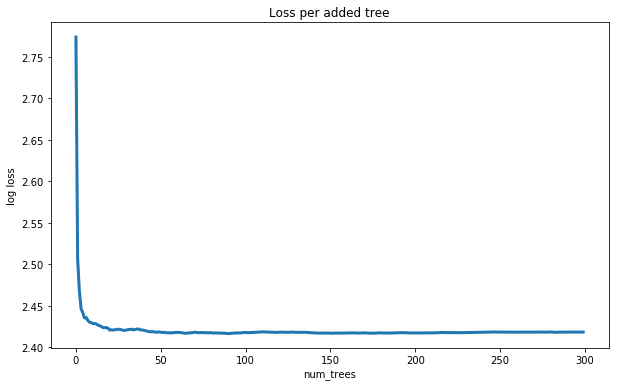

In [45]:
# How to find sufficient `n_estimators` in Random Forest
predictions = [tree.predict_proba(X_test)[None, :] for tree in rf.estimators_]    
predictions = np.vstack(predictions)

cum_mean = np.cumsum(predictions, axis=0) / np.arange(1, predictions.shape[0] + 1)[:, None, None]
scores = [log_loss(y_test, pred) for pred in cum_mean]

plt.figure(figsize=(10, 6))
plt.plot(scores, linewidth=3)
plt.title('Loss per added tree')
plt.xlabel('num_trees')
plt.ylabel('log loss');

# Bagging

In [51]:
# bagging random forest

rf = RandomForestClassifier(n_estimators=50, n_jobs=4, max_depth=7)
bags = 10
seed = 1

bagged_predictions = np.zeros((len(X_test), len(set(y_train_sample))))

for i in range(bags):
    print('model', i)
    rf.set_params(random_state=seed+i)
    rf.fit(X_train_sample, y_train_sample)
    preds = rf.predict_proba(X_test)
    bagged_predictions += preds
    
bagged_predictions /= bags

print(log_loss(y_test, bagged_predictions))

model 0
model 1
model 2
model 3
model 4
model 5
model 6
model 7
model 8
model 9


# weight boosting 

In [119]:
from sklearn.ensemble import AdaBoostClassifier

rf = RandomForestClassifier(n_estimators=10, max_depth=7)

ada = AdaBoostClassifier(base_estimator=rf, learning_rate=0.1, n_estimators=100)
ada.fit(X_train_sample, y_train_sample)
preds_train = ada.predict_proba(X_train_sample)
preds_test = ada.predict_proba(X_test)

print(log_loss(y_train_sample, preds_train))
print(log_loss(y_test, preds_test))

2.987668816590355
3.018005901190654


In [36]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=50, n_jobs=4, max_depth=7)
rf.fit(X_train_sample, y_train_sample)
print_score(rf, X_train_sample, y_train_sample, X_test, y_test)

RandomForestClassifier train/test classification accuracies: 0.293/0.289
RandomForestClassifier train/test log loss: 2.372/2.391


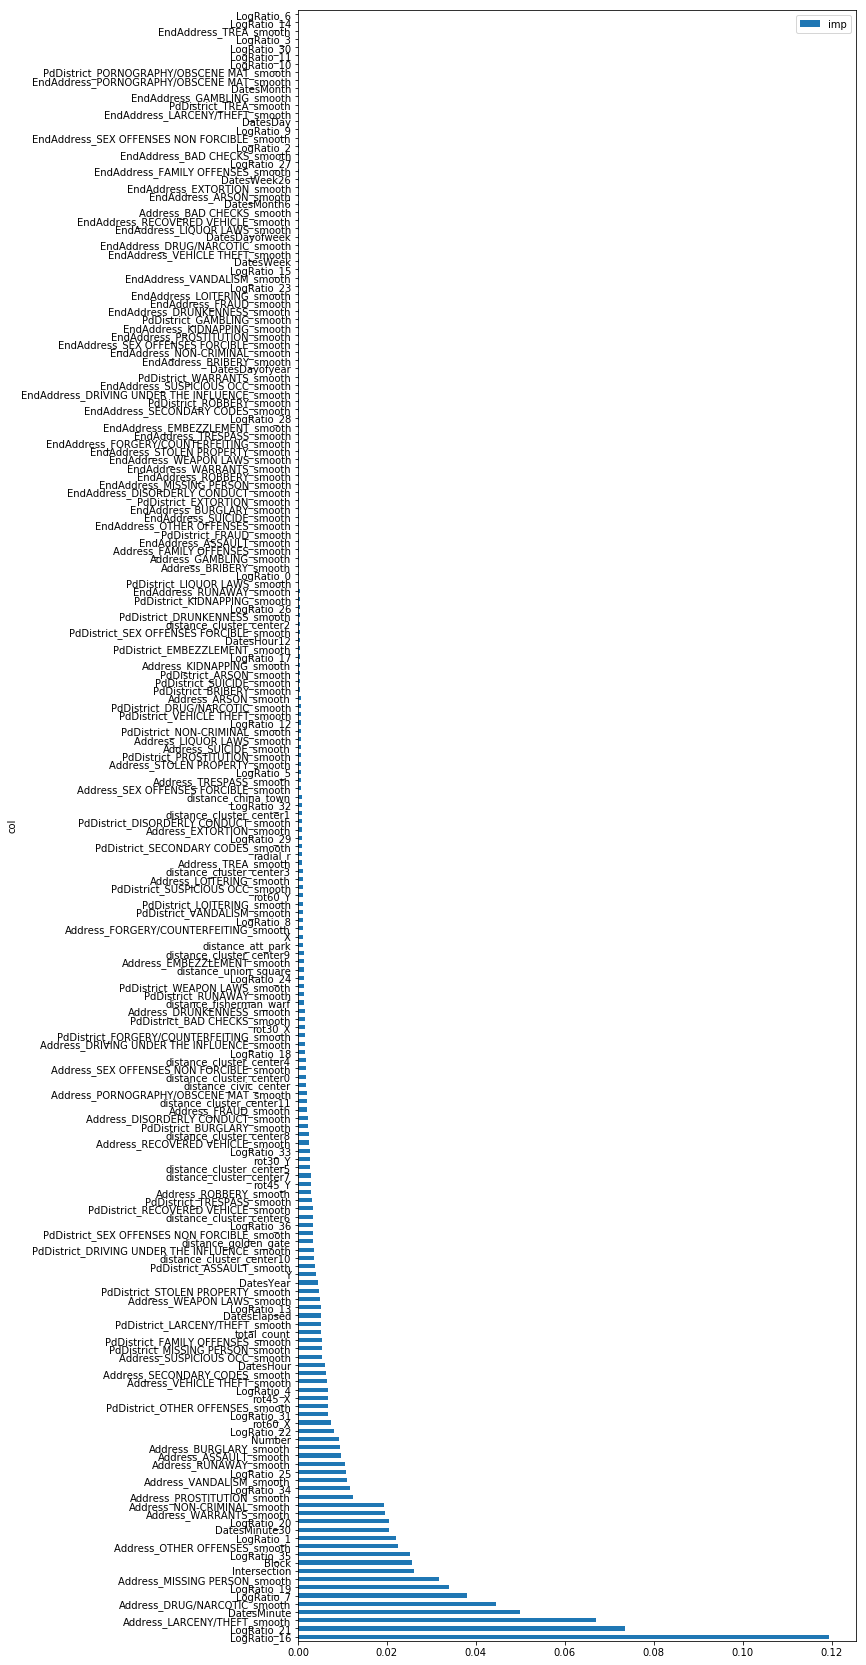

In [37]:
plt.figure(figsize=(30, 10))
fi = pd.DataFrame.from_dict({'col': X_train_sample.columns, 'imp': rf.feature_importances_}).sort_values('imp', ascending=False)
fi.set_index('col').plot(kind='barh', figsize=(10, 30));

In [38]:
# feature importance feature selection

cutoff = 0.001
reduced_features = fi[fi['imp'] > cutoff].col.tolist()
fi[fi['imp'] > cutoff].shape

(94, 2)

In [39]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=4, max_depth=10)
rf.fit(X_train_sample[reduced_features], y_train_sample)
print_score(rf, X_train_sample[reduced_features], y_train_sample, X_test[reduced_features], y_test)

RandomForestClassifier train/test classification accuracies: 0.323/0.308
RandomForestClassifier train/test log loss: 2.228/2.327


[0.745051   0.81578965 0.86124119 0.88502986 0.90824759 0.93095999
 0.9530112  0.97019498 0.98168956 0.98737432 0.99153477 0.9949655
 0.99627828 0.9971732  0.99787604]


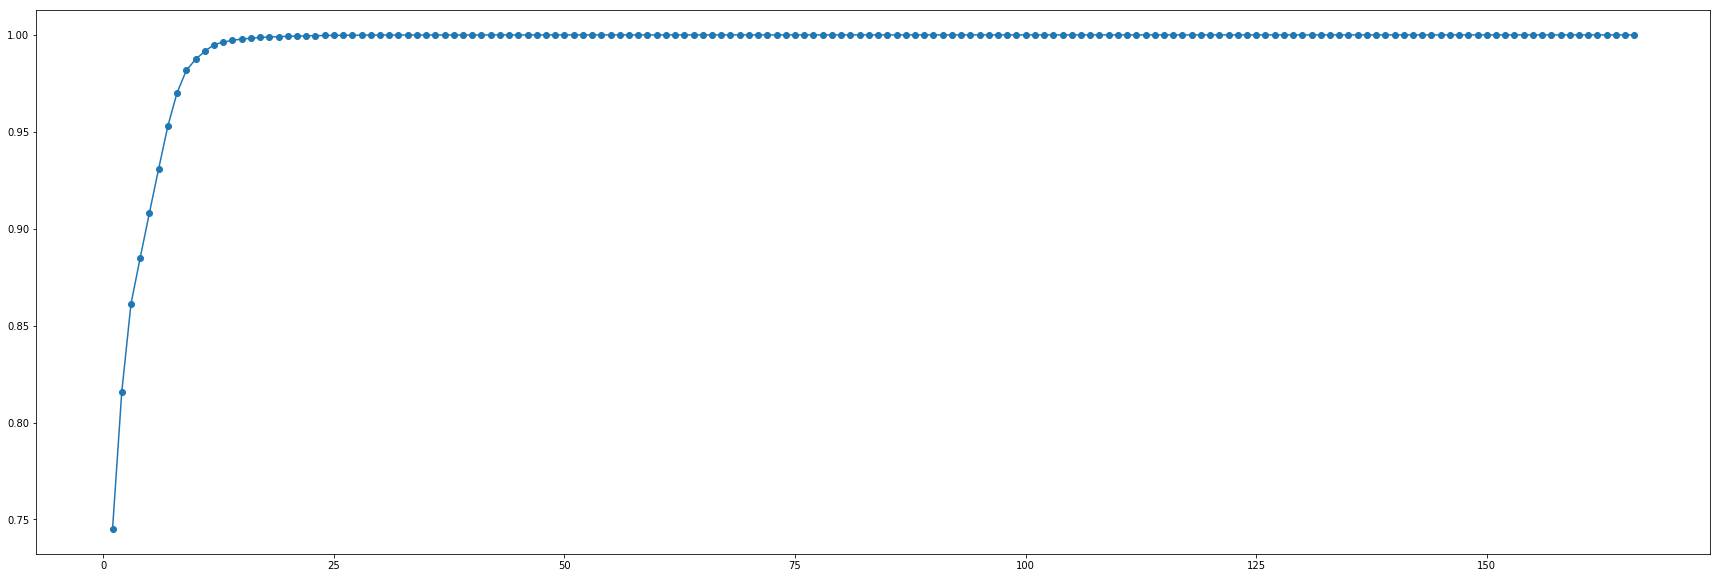

In [142]:
# PCA 

from sklearn.decomposition import PCA
plt.figure(figsize=(30, 10))
pca = PCA(X_train.shape[1])
pca.fit(X_train_sample)

print(np.cumsum(pca.explained_variance_ratio_)[:15])
x = np.arange(1, X_train.shape[1]+1)
plt.plot(x, np.cumsum(pca.explained_variance_ratio_), '-o')

In [143]:
pca = PCA(25)
pca_X_train_sample = pca.fit_transform(X_train_sample)
pca_X_test = pca.transform(X_test)

In [144]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=4, max_depth=10)
rf.fit(pca_X_train_sample, y_train_sample)
print_score(rf, pca_X_train_sample, y_train_sample, pca_X_test, y_test)

RandomForestClassifier train/test classification accuracies: 0.295/0.283
RandomForestClassifier train/test log loss: 2.321/2.403


In [155]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

lr = LogisticRegression()
lr.fit(pca_X_train_sample, y_train_sample)

print_score(lr, pca_X_train_sample, y_train_sample, pca_X_test, y_test)

LogisticRegression train/test classification accuracies: 0.276/0.278
LogisticRegression train/test log loss: 2.417/2.422


In [ ]:
print_score(cclf, pca_X_train_sample, y_train_sample, pca_X_test, y_test)

In [28]:
# Deep Learning 
from keras.models import Model, Input
from keras.layers import Dense, Dropout, Flatten

def get_fully_connected_model(X_train):
    input_ = Input(shape=(X_train.shape[1], ))
    X = Dense(128, activation='relu')(input_)
    X = Dropout(0.1)(X)
    X = Dense(256, activation='relu')(X)
    X = Dropout(0.1)(X)
    X = Dense(128, activation='relu')(X)
    X = Dropout(0.1)(X)
    X = Dense(len(le.classes_), activation='softmax')(X)
    
    model = Model(input_, X)
    model.compile('adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
    return model

/home/matt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [29]:
model = get_fully_connected_model(X_train_sample)
# model = get_fully_connected_model(pca_X_train_sample)
model.fit(X_train_sample, y_train_sample, validation_split=0.1, epochs=10)
# model.fit(pca_X_train_sample, y_train_sample, validation_split=0.1, epochs=10)

Train on 177804 samples, validate on 19757 samples
Epoch 1/10
177804/177804 [==============================] - 21s 118us/step - loss: 2.3651 - acc: 0.3005 - val_loss: 2.3028 - val_acc: 0.3122
Epoch 2/10
177804/177804 [==============================] - 20s 113us/step - loss: 2.3079 - acc: 0.3118 - val_loss: 2.2942 - val_acc: 0.3139
Epoch 3/10
177804/177804 [==============================] - 20s 114us/step - loss: 2.2918 - acc: 0.3157 - val_loss: 2.2833 - val_acc: 0.3183
Epoch 4/10
177804/177804 [==============================] - 20s 113us/step - loss: 2.2815 - acc: 0.3173 - val_loss: 2.2775 - val_acc: 0.3185
Epoch 5/10
177804/177804 [==============================] - 20s 114us/step - loss: 2.2733 - acc: 0.3192 - val_loss: 2.2771 - val_acc: 0.3197
Epoch 6/10
177804/177804 [==============================] - 20s 114us/step - loss: 2.2665 - acc: 0.3204 - val_loss: 2.2755 - val_acc: 0.3199
Epoch 7/10
177804/177804 [==============================] - 20s 114us/step - loss: 2.2625 - acc: 0.3203

In [150]:
model.fit(X_train_sample[reduced_features], y_train_sample, validation_split=0.1, epochs=10)

Train on 177804 samples, validate on 19757 samples
Epoch 1/10
177804/177804 [==============================] - 14s 81us/step - loss: 2.3055 - acc: 0.3013 - val_loss: 2.3009 - val_acc: 0.3038
Epoch 2/10
177804/177804 [==============================] - 14s 81us/step - loss: 2.3031 - acc: 0.3017 - val_loss: 2.2954 - val_acc: 0.3027
Epoch 3/10
177804/177804 [==============================] - 14s 80us/step - loss: 2.2997 - acc: 0.3031 - val_loss: 2.2942 - val_acc: 0.3020
Epoch 4/10
177804/177804 [==============================] - 14s 81us/step - loss: 2.2984 - acc: 0.3033 - val_loss: 2.2929 - val_acc: 0.3048
Epoch 5/10
177804/177804 [==============================] - 14s 80us/step - loss: 2.2956 - acc: 0.3041 - val_loss: 2.2908 - val_acc: 0.3041
Epoch 6/10
177804/177804 [==============================] - 14s 80us/step - loss: 2.2943 - acc: 0.3046 - val_loss: 2.2907 - val_acc: 0.3065
Epoch 7/10
177804/177804 [==============================] - 14s 81us/step - loss: 2.2916 - acc: 0.3047 - val_

In [ ]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

xgb_hyper = {
    'max_depth': 7,
    'n_estimators': 200,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 20,
    'tree_method': 'gpu_hist'
}

xgb_model = XGBClassifier(**xgb_hyper)
xgb_model.fit(X_train_sample, y_train_sample, eval_set = [(X_train_sample, y_train_sample), (X_test, y_test)], 
              eval_metric = 'mlogloss', verbose = 10, 
              early_stopping_rounds=20)

In [104]:
from keras import backend as K

def limit_mem():
    K.get_session().close()
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))
       
limit_mem() 

In [109]:
from collections import OrderedDict
embedding_features = cat_cols + all_date_cols

embedding_features_map = OrderedDict({col: X_train[col].nunique() for col in embedding_features})
embedding_features_map

In [105]:
def split_features(X, embedding_features_map):
    X_list = []    
    for col, _ in embedding_features_map.items():        
        column = X[col].tolist()
        X_list.append(np.array(column))
    return X_list

In [106]:
from keras.models import Model, Input
from keras.layers import Dense, Dropout, Flatten, Embedding, Reshape, concatenate, Activation

def get_embedding_model():
    
    # create embeddings 
    input_embeddings_model = []
    output_embeddings_model = []
    for col, value in embedding_features_map.items():      
        embed_size = min((value // 2), 50)
        input_ = Input(shape=(1,))
        output_ = Embedding(value, embed_size, name= str(col) + '_embed')(input_)
        output_ = Reshape(target_shape=(embed_size,))(output_)
        input_embeddings_model.append(input_)
        output_embeddings_model.append(output_)
       
    output_model = concatenate(output_embeddings_model)
    output_model = Dense(1000, kernel_initializer="uniform")(output_model)
    output_model = Activation('relu')(output_model)
    output_model = Dense(500, kernel_initializer="uniform")(output_model)
    output_model = Activation('relu')(output_model)
    output_model = Dense(len(le.classes_), activation='softmax')(output_model)
    
    model = Model(input_embeddings_model, output_model)
    model.compile('adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
    return model

In [1]:
embed_model = get_embedding_model()
embed_model.fit(split_features(X_train_sample, embedding_features_map), y_train_sample, validation_split=0.1, epochs=5)

In [52]:
# import tensorflow as tf
# tf.reset_default_graph()

from keras.models import Model, Input
from keras.layers import Dense, Dropout, Flatten, Embedding, Reshape, concatenate, Activation, SpatialDropout1D

def get_mixed_model():
    
    # create numerical features 
    input_num = Input(shape=(X_train_sample_num.shape[1], ), name='numeric_input')    
    input_model = [input_num]

    # create categorcial embeddings 
    for col, value in embedding_features_map.items():      
        embed_size = min((value // 2), 50)
        input_cat = Input(shape=(1,), name=str(col) + '_input')
        output_cat = Embedding(value, embed_size, name= str(col) + '_embed')(input_cat)
        output_cat = Reshape(target_shape=(embed_size,))(output_cat)
        input_model.append(input_cat)
        output_model = concatenate(input_model)

    output_model = Dropout(0.1)(output_model)
    output_model = Dense(256, activation='relu')(output_model)
    output_model = Dropout(0.1)(output_model)
    output_model = Dense(128, activation='relu')(output_model)
    output_model = Dropout(0.1)(output_model)
    output_model = Dense(len(le.classes_), activation='softmax')(output_model)
    
    model = Model(input_model, output_model)
    model.compile('adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
  
    return model

In [34]:
X_train_sample_num = X_train_sample[list(set(list(X_train_sample.columns)).difference(embedding_features))]

In [57]:
embed_model = get_mixed_model()                 

In [38]:
# embed_model.summary()

In [2]:
embed_model.optimizer.lr = 0.01

embed_model.fit([X_train_sample_num.as_matrix()] + split_features(X_train_sample, embedding_features_map), 
                y_train_sample, validation_split=0.1, epochs=10)

In [60]:
preds = embed_model.predict([X_train_sample_num.as_matrix()] + split_features(X_train_sample, embedding_features_map))

In [64]:
from keras.models import Model, Input
from keras.layers import Dense, Dropout, Flatten, Embedding, Reshape, concatenate, Activation, SpatialDropout1D

def get_mixed_model2():
    
    # create numerical features 
    input_num = Input(shape=(X_train_sample_num.shape[1], ), name='numeric_input')    

    input_cat = Input((len(embedding_features_map), ))
    
    x_cat = Embedding(22975, 20)(input_cat)
    x_cat = SpatialDropout1D(0.1)(x_cat)
    x_cat = Flatten()(x_cat)
    
    output_model = concatenate([input_num, x_cat])
    output_model = Dropout(0.1)(output_model)
    output_model = Dense(256, activation='relu')(output_model)
    output_model = Dropout(0.1)(output_model)
    output_model = Dense(128, activation='relu')(output_model)
    output_model = Dropout(0.1)(output_model)
    output_model = Dense(len(le.classes_), activation='softmax')(output_model)
    
    model = Model([input_num, input_cat], output_model)
    model.compile('adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
  
    return model

In [65]:
embed_model2 = get_mixed_model2()      

In [3]:
embed_model2.fit([np.array(split_features(X_train_sample, embedding_features_map)), X_train_sample_num.as_matrix().T], 
                y_train_sample, validation_split=0.1, epochs=3)

### PyTorch MultiInputNN

In [114]:
import torch
from torch import nn
from torch.nn.init import kaiming_normal
import torch.nn.functional as F
from torch.optim import RMSprop
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.optim.optimizer import Optimizer


def init_embeddings(x):
    x = x.weight.data
    value = 2 / (x.size(1) + 1)
    x.uniform_(-value, value)
    
    
class MultiInputNN(nn.Module):
    def __init__(self, emb_szs, n_cont, emb_drop, out_sz, sizes, drops, y_range=None, use_bn=False, f=F.relu):
        super().__init__()
        # embedding layers
        self.embeddings = nn.ModuleList([nn.Embedding(insize, outsize) for insize, outsize in emb_szs])
        for layer in self.embeddings:
            init_embeddings(layer)
        self.num_categorical = sum([layer.embedding_dim for layer in self.embeddings])
        self.num_numerical = n_cont
        # linear layers
        sizes = [self.num_categorical + self.num_numerical] + sizes
        self.linear = nn.ModuleList([nn.Linear(sizes[i], sizes[i+1]) for i in range(len(sizes)-1)])
        self.bns = nn.ModuleList([nn.BatchNorm1d(size) for size in sizes[1:]])
        for layer in self.linear:
            kaiming_normal(layer.weight.data)
        # dropout layers 
        self.emb_drop = nn.Dropout(emb_drop)
        self.drop_out = [nn.Dropout(drop) for drop in drops]
        # output layer
        self.output = nn.Linear(sizes[-1], len(le.classes_))
        kaiming_normal(self.output.weight.data)
        self.f = f
        self.bn = nn.BatchNorm1d(self.num_numerical)
        self.use_bn = use_bn
        self.y_range = y_range

    def forward(self, x_cat, x_cont):
        if self.num_categorical > 0:
            print(len(x_cat))
            print(self.embeddings)
            X = [emb_layer(x_cat[:,i]) for i, emb_layer in enumerate(self.embeddings)]
            X = torch.cat(X, dim=1)
            X = self.emb_drop(X)
        if self.num_numerical > 0:
            X2 = self.bn(x_cont)
            X = torch.cat([X, X2], dim=1) if self.num_categorical != 0 else X2
        for linear, drop, norm in zip(self.linear, self.drop_out, self.bns):
            X = self.f(linear(X))
            if self.use_bn: 
                X = norm(X)
            X = drop(X)
        X = F.log_softmax(self.output(X), dim=-1)
        return X

def one_hot(y, K):
    return np.eye(K)[y]
    
class StructuredDataSet(Dataset):
    def __init__(self, cats, conts, y):
        self.cats = np.asarray(cats, dtype=np.int64)
        self.conts = np.asarray(conts, dtype=np.float32)
        self.N = len(y)
        y = one_hot(y, len(le.classes_))
        self.y = np.asarray(y, dtype=np.float32)
            
    def __len__(self): 
        return len(self.y)

    def __getitem__(self, idx):
        return [self.cats[idx].T, self.conts[idx], self.y[idx]]

In [115]:
emb_c = embedding_features_map
emb_szs = [(c, min(50, (c+1)//2)) for _,c in emb_c.items()]


torch_model = MultiInputNN(emb_szs, len(embedding_features), 0.05, 1, [500,250], [0.5,0.05], use_bn=True)

In [118]:
train_set = DataLoader(StructuredDataSet(X_train_sample[embedding_features], X_train_sample_num, y_train_sample), 
                      batch_size=12, shuffle=True, num_workers=4)

In [4]:
optimizer = RMSprop(torch_model.parameters(), lr=0.1)
loss = nn.NLLLoss()


for i, (batch_cat, batch_cont, batch_y) in enumerate(train_set):
        optimizer.zero_grad()
        batch_cat, batch_cont, batch_y = Variable(batch_cat).long(), Variable(batch_cont), Variable(batch_y)

        y_hat = torch_model(batch_cat, batch_cont)
        print(y_hat)
        break

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import NearestNeighbors
from multiprocessing import Pool
from math import ceil
# from more_itertools import chunked
from itertools import chain

import numpy as np

def flattenlist(listoflists):
    return list(chain.from_iterable(listoflists))


class NearestNeighborsFeats(BaseEstimator, ClassifierMixin):
    '''
        This class should implement KNN features extraction 
    '''
    def __init__(self, n_jobs, k_list, metric, n_classes=None, n_neighbors=None, eps=1e-6):
        self.n_jobs = n_jobs
        self.k_list = k_list
        self.metric = metric
        
        if n_neighbors is None:
            self.n_neighbors = max(k_list) 
        else:
            self.n_neighbors = n_neighbors
            
        self.eps = eps        
        self.n_classes_ = n_classes
    
    def fit(self, X, y):
        '''
            Set's up the train set and self.NN object
        '''
        # Create a NearestNeighbors (NN) object. We will use it in `predict` function 
        self.NN = NearestNeighbors(n_neighbors=max(self.k_list), 
                                      metric=self.metric, 
                                      n_jobs=1, 
                                      algorithm='brute' if self.metric=='cosine' else 'auto')
        self.NN.fit(X)
        
        # Store labels 
        self.y_train = y
        
        # Save how many classes we have
        self.n_classes = np.unique(y).shape[0] if self.n_classes_ is None else self.n_classes_
        
        
    def predict(self, X):       
        '''
            Produces KNN features for every object of a dataset X
        '''
        if self.n_jobs == 1:
            test_feats = []
            for i in range(X.shape[0]):
                test_feats.append(self.get_features_for_one(X[i:i+1]))
        else:
            '''
                 *Make it parallel*
                     Number of threads should be controlled by `self.n_jobs`  
                     
                     
                     You can use whatever you want to do it
                     For Python 3 the simplest option would be to use 
                     `multiprocessing.Pool` (but don't use `multiprocessing.dummy.Pool` here)
                     You may try use `joblib` but you will most likely encounter an error, 
                     that you will need to google up (and eventually it will work slowly)
                     
                     For Python 2 I also suggest using `multiprocessing.Pool` 
                     You will need to use a hint from this blog 
                     http://qingkaikong.blogspot.ru/2016/12/python-parallel-method-in-class.html
                     I could not get `joblib` working at all for this code 
                     (but in general `joblib` is very convenient)
                     
            '''
            
            test_feats = Pool(self.n_jobs).map(self.get_features_for_one, (X[i:i+1] for i in range(X.shape[0])))
            assert False, 'You need to implement it for n_jobs > 1'
            
            
            
        return np.vstack(test_feats)
        
        
    def get_features_for_one(self, x):
        '''
            Computes KNN features for a single object `x`
        '''

        NN_output = self.NN.kneighbors(x)
        
        # Vector of size `n_neighbors`
        # Stores indices of the neighbors
        neighs = NN_output[1][0]
        
        # Vector of size `n_neighbors`
        # Stores distances to corresponding neighbors
        neighs_dist = NN_output[0][0] 

        # Vector of size `n_neighbors`
        # Stores labels of corresponding neighbors
        neighs_y = self.y_train[neighs] 
        
       
        # We will accumulate the computed features here
        # Eventually it will be a list of lists or np.arrays
        # and we will use np.hstack to concatenate those
        return_list = [] 
        
        
        ''' 
            1. Fraction of objects of every class.
               It is basically a KNNСlassifiers predictions.

               Take a look at `np.bincount` function, it can be very helpful
               Note that the values should sum up to one
        '''
        for k in self.k_list:

            feats = np.bincount(np.array(neighs_y[:k]), minlength=self.n_classes)
            feats  = feats / (feats.sum())
            
            assert len(feats) == self.n_classes
            return_list += [feats]
        
        
        '''
            2. Same label streak: the largest number N, 
               such that N nearest neighbors have the same label.
               
               What can help you: `np.where`
        '''
       
        feats = 1 + np.where(np.append(neighs_y[:-1] != neighs_y[1:], True))[0].min(keepdims=True)
        
        assert len(feats) == 1
        return_list += [feats]
        
        '''
            3. Minimum distance to objects of each class
               Find the first instance of a class and take its distance as features.
               
               If there are no neighboring objects of some classes, 
               Then set distance to that class to be 999.

               `np.where` might be helpful
        '''
        feats = []
        for c in range(self.n_classes):
            feats.append(np.append(neighs_dist[neighs_y == c], 999).min())
        
        assert len(feats) == self.n_classes
        return_list += [feats]
        
        '''
            4. Minimum *normalized* distance to objects of each class
               As 3. but we normalize (divide) the distances
               by the distance to the closest neighbor.
               
               If there are no neighboring objects of some classes, 
               Then set distance to that class to be 999.
               
               Do not forget to add self.eps to denominator.
        '''
        feats = []
        for c in range(self.n_classes):
            
            f = neighs_dist[neighs_y == c] / (neighs_dist[0] + self.eps)
            if f.size: feats.append(f.min())
            else: feats.append(999)
        
        assert len(feats) == self.n_classes
        return_list += [feats]
        
        '''
            5. 
               5.1 Distance to Kth neighbor
                   Think of this as of quantiles of a distribution
               5.2 Distance to Kth neighbor normalized by 
                   distance to the first neighbor
               
               feat_51, feat_52 are answers to 5.1. and 5.2.
               should be scalars
               
               Do not forget to add self.eps to denominator.
        '''
        for k in self.k_list:
            
            feat_51 = neighs_dist[k-1]
            feat_52 = neighs_dist[k-1] / (neighs_dist[0] + self.eps)
            
            return_list += [[feat_51, feat_52]]
        
        '''
            6. Mean distance to neighbors of each class for each K from `k_list` 
                   For each class select the neighbors of that class among K nearest neighbors 
                   and compute the average distance to those objects
                   
                   If there are no objects of a certain class among K neighbors, set mean distance to 999
                   
               You can use `np.bincount` with appropriate weights
               Don't forget, that if you divide by something, 
               You need to add `self.eps` to denominator.
        '''
        for k in self.k_list:
            
            counts = np.bincount(neighs_y[:k], minlength=self.n_classes)
            counts_weights = np.bincount(neighs_y[:k], weights=neighs_dist[:k], minlength=self.n_classes) / (counts + self.eps)
            feats = np.where(counts, counts_weights, 999)
            
            assert len(feats) == self.n_classes
            return_list += [feats]
        
        
        # merge
        knn_feats = np.hstack(return_list)
        
        assert knn_feats.shape == (239,) or knn_feats.shape == (239, 1)
        return knn_feats